  # Aluminum Price prediction using Time series forecasting



# 1. Objective
Aluminum is one of the most widely used metal in the manufacturing, especially aviation industry with high processing cost. Objective of this report is to compare significant predictive methods to point forecast the global Aluminum prices using the set of most comprehensive features such as production, demand, inventory and producer price index (PPI) 

In [661]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

# 2. Data collection, cleaning and pre-processing 

In [662]:
import pmdarima as pm

In [663]:
raw= pd.read_csv("C:/Users/mayan/OneDrive/Desktop/Commodities/Aluminium/AL Global price.csv")

In [664]:
alprice=raw.copy()

In [665]:
alprice['g_price']=alprice['PALUMUSDM']

In [666]:
alprice.drop(['PALUMUSDM'],inplace=True, axis=1)

In [667]:
alprod= pd.read_csv("C:/Users/mayan/OneDrive/Desktop/Commodities/Aluminium/AL Industrial Production.csv")

In [668]:
al_inv= pd.read_csv("C:/Users/mayan/OneDrive/Desktop/Commodities/Aluminium/AL Manufacturers' Total Inventories.csv")

In [669]:
al_demand= pd.read_csv("C:/Users/mayan/OneDrive/Desktop/Commodities/Aluminium/AL Mfg new orders.csv")

In [670]:
al_PPI= pd.read_csv("C:/Users/mayan/OneDrive/Desktop/Commodities/Aluminium/AL Producer Price Index by Industry.csv")

In [671]:
al_inv.head()

,DATE,AANMTI
0,1995-01-01,8535.0
1,1995-02-01,8635.0
2,1995-03-01,8712.0
3,1995-04-01,8773.0
4,1995-05-01,8724.0


In [672]:
alprice['prod']=alprod['IPG3313S']

In [673]:
alprice['inv']=al_inv['AANMTI']

In [674]:
al_demand.head(2)

,DATE,AANMNO
0,1995-01-01,6210.0
1,1995-02-01,5940.0


In [675]:
alprice['demand']=al_demand['AANMNO']

In [676]:
al_PPI.head(2)

,DATE,PCU3313153313150
0,1995-01-01,162.0
1,1995-02-01,170.9


In [677]:
alprice['PPI']=al_PPI['PCU3313153313150']

In [678]:
alprice.head(3)

,DATE,g_price,prod,inv,demand,PPI
0,1995-01-01,2059.357178,101.9277,8535.0,6210.0,162.0
1,1995-02-01,1905.449951,100.2404,8635.0,5940.0,170.9
2,1995-03-01,1799.978271,97.5724,8712.0,6037.0,174.5


In [679]:
alprice.columns

Index(['DATE', 'g_price', 'prod', 'inv', 'demand', 'PPI'], dtype='object')

# 3. DATA Exploration

In [680]:
alprice['DATE']= pd.to_datetime(alprice['DATE'])

In [681]:
alprice.dtypes

DATE       datetime64[ns]
g_price           float64
prod              float64
inv               float64
demand            float64
PPI               float64
dtype: object

In [682]:
al=alprice.copy()

In [683]:
al.set_index(['DATE'],inplace=True)

In [684]:
al.columns

Index(['g_price', 'prod', 'inv', 'demand', 'PPI'], dtype='object')

In [685]:
al.shape

(323, 5)

In [686]:
al = al.astype(int)

In [687]:
al.tail()

,g_price,prod,inv,demand,PPI
DATE,,,,,
2021-07-01,2497,103,11821,7156,224
2021-08-01,2602,104,11901,6918,232
2021-09-01,2834,97,11929,6723,239
2021-10-01,2934,106,12110,6898,250
2021-11-01,2636,107,12182,6853,255


Text(0.5, 1.0, 'Al price($/MT) 1995 to 2021')

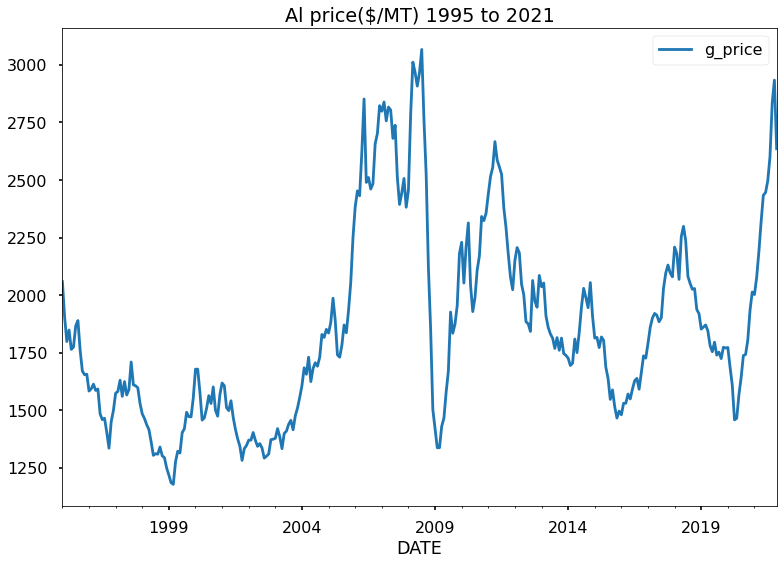

In [688]:
al[['g_price']].plot()
plt.title('Al price($/MT) 1995 to 2021')

Text(0.5, 1.0, 'log scale')

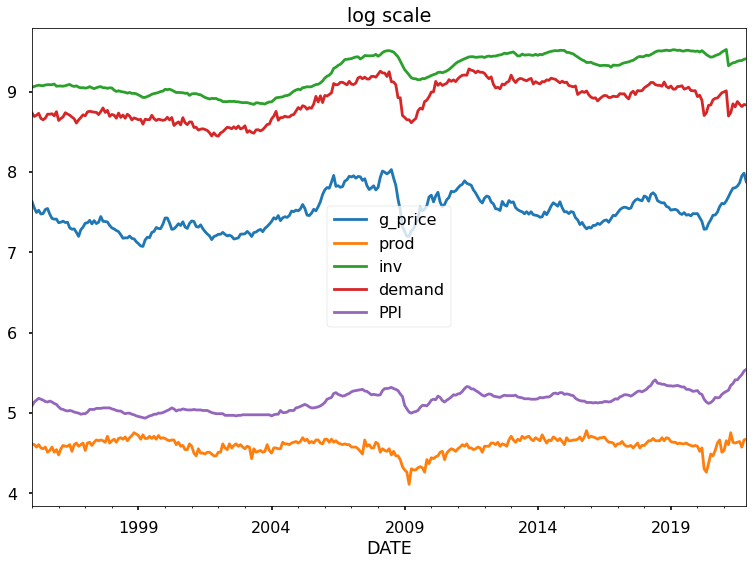

In [689]:
np.log(al).plot()
plt.title('log scale')

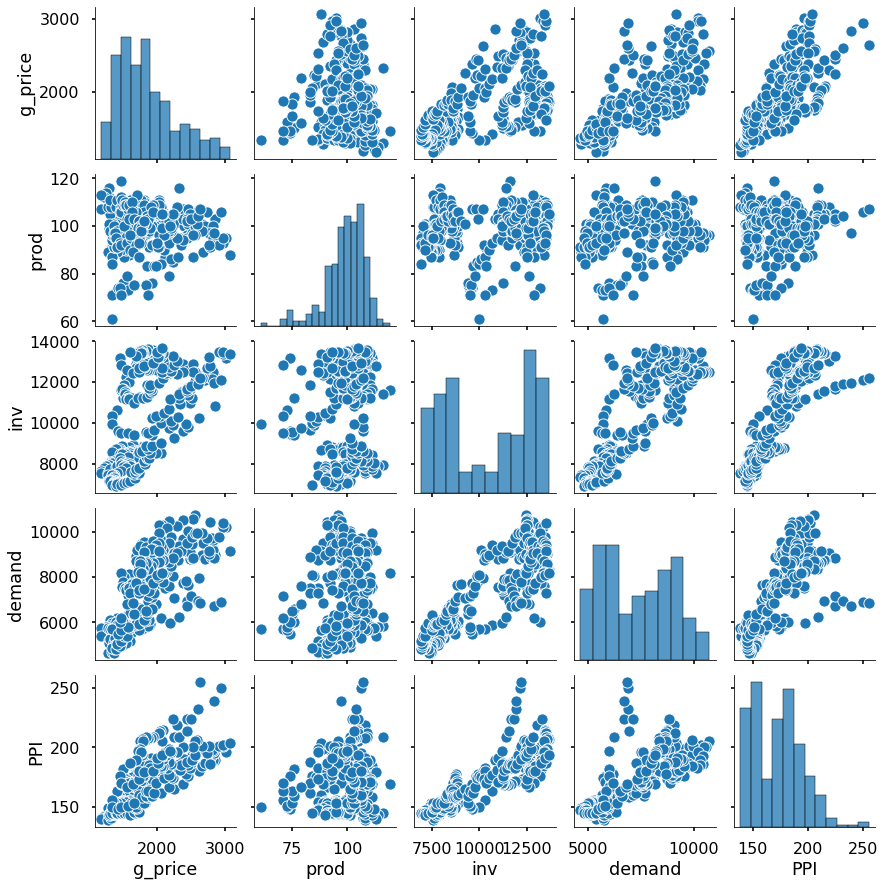

In [690]:
sns.pairplot(al)

In [691]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
model = scaler.fit(al)
scaled_data = model.transform(al)

Text(0.5, 1.0, 'Last 7 year behavior (Scaled data)')

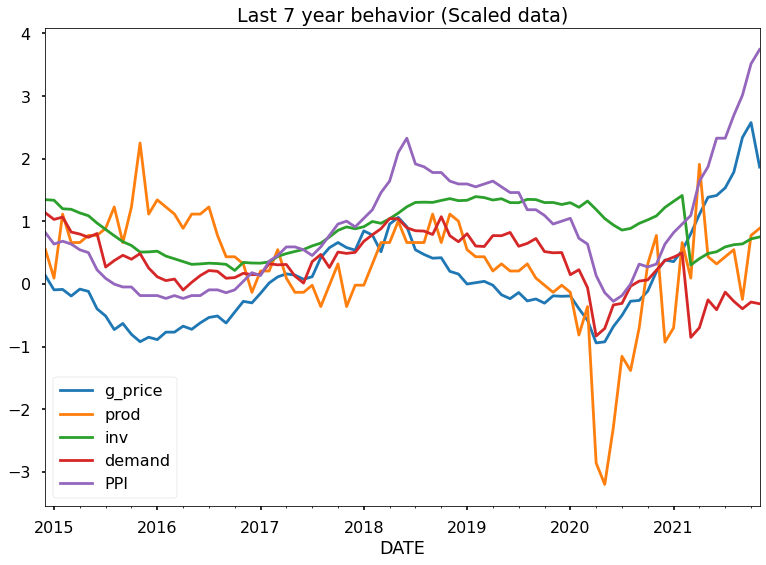

In [692]:
scaled=pd.DataFrame(scaled_data, columns=al.columns, index=al.index)
scaled[-84:].plot()
plt.title('Last 7 year behavior (Scaled data)')

array([<AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
       <AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
       <AxesSubplot:xlabel='DATE'>], dtype=object)

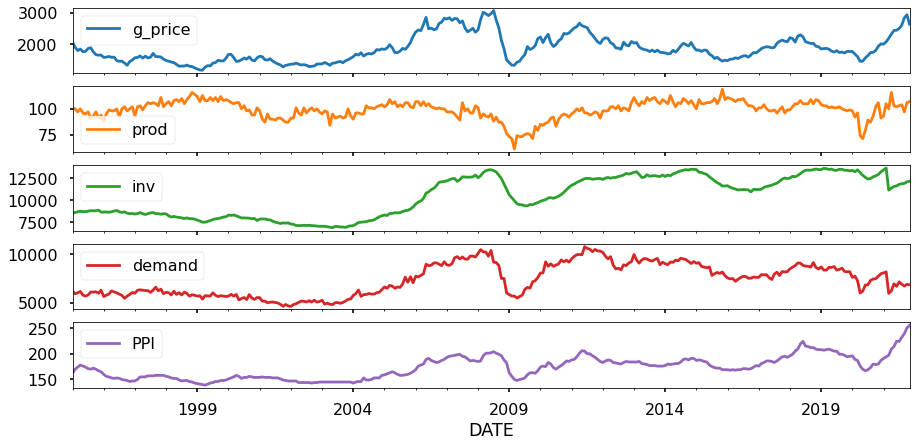

In [693]:
al[['g_price', 'prod', 'inv', 'demand', 'PPI']].plot(subplots=True, figsize=(15,7))

In [694]:
def percent_change(col):
    al['ch_'+col]=((al[col]/(al[col].shift(1))-1)).round(2)

In [695]:
percent_change('g_price')

In [696]:
percent_change('prod')

In [697]:
percent_change('inv')

In [698]:
percent_change('demand')

In [699]:
percent_change('PPI')

In [700]:
al.tail(2)

,g_price,prod,inv,demand,PPI,ch_g_price,ch_prod,ch_inv,ch_demand,ch_PPI
DATE,,,,,,,,,,
2021-10-01,2934,106,12110,6898,250,0.04,0.09,0.02,0.03,0.05
2021-11-01,2636,107,12182,6853,255,-0.10,0.01,0.01,-0.01,0.02


In [701]:
al.columns

Index(['g_price', 'prod', 'inv', 'demand', 'PPI', 'ch_g_price', 'ch_prod',
       'ch_inv', 'ch_demand', 'ch_PPI'],
      dtype='object')

<AxesSubplot:title={'center':'Last 5 yr changes'}, xlabel='DATE'>

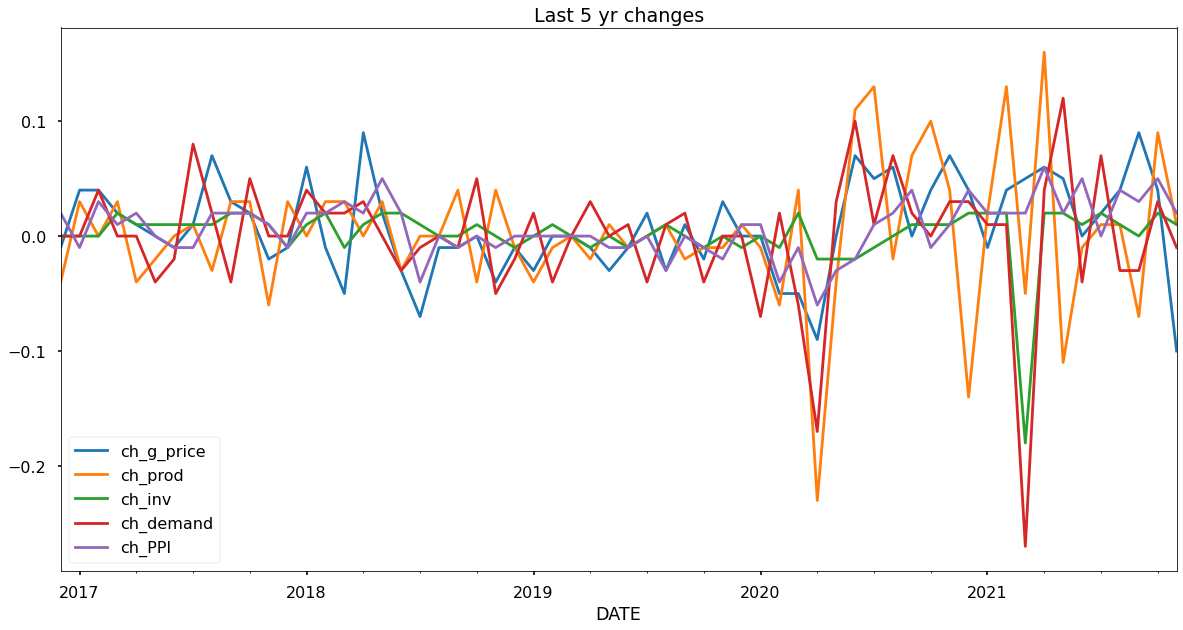

In [702]:
al[['ch_g_price', 'ch_prod','ch_inv', 'ch_demand', 'ch_PPI']][-60:].plot(figsize=(20,10),title='Last 5 yr changes')

<AxesSubplot:title={'center':'Price Vs Production -10 yr changes'}, xlabel='DATE'>

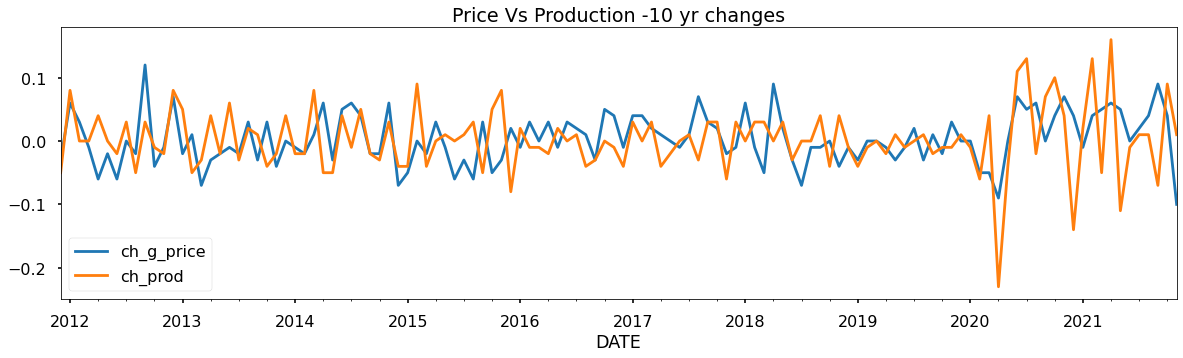

In [703]:
al[['ch_g_price', 'ch_prod']][-120:].plot(figsize=(20,5),title='Price Vs Production -10 yr changes')

In [704]:
al[['ch_g_price', 'ch_prod']][-60:].corr()                       #Last 5 year's correlation

,ch_g_price,ch_prod
ch_g_price,1.000000,0.263955
ch_prod,0.263955,1.000000


<AxesSubplot:title={'center':'Price Vs PPI -10 yr changes'}, xlabel='DATE'>

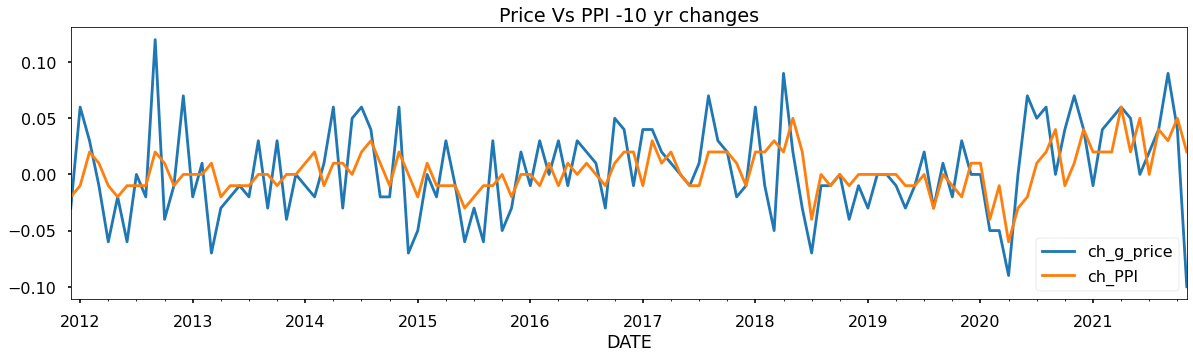

In [705]:
al[['ch_g_price', 'ch_PPI']][-120:].plot(figsize=(20,5),title='Price Vs PPI -10 yr changes')

In [706]:
al[['ch_g_price', 'ch_PPI']].describe()

,ch_g_price,ch_PPI
count,322.000000,322.000000
mean,0.001801,0.001584
std,0.046549,0.018720
min,-0.190000,-0.100000
25%,-0.030000,-0.010000
50%,0.000000,0.000000
75%,0.030000,0.010000
max,0.150000,0.060000


In [707]:
scaled.columns

Index(['g_price', 'prod', 'inv', 'demand', 'PPI'], dtype='object')

<AxesSubplot:title={'center':'Price Vs Inv -10 yr changes'}, xlabel='DATE'>

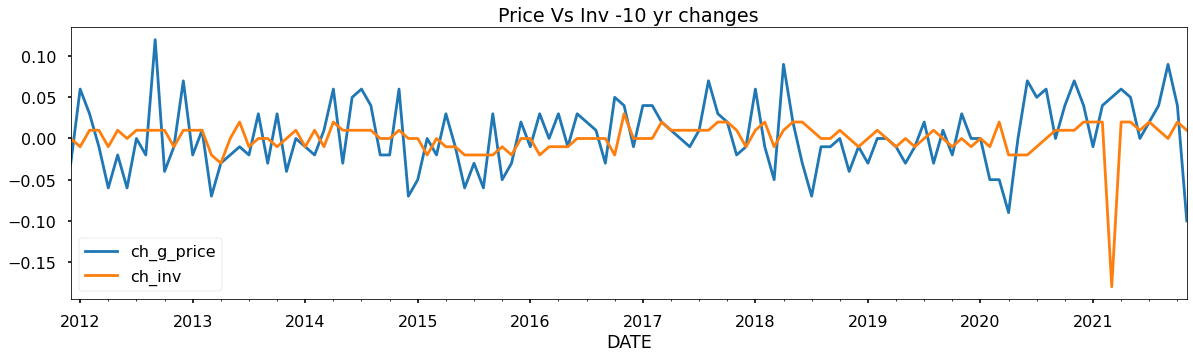

In [708]:
al[['ch_g_price', 'ch_inv']][-120:].plot(figsize=(20,5),title='Price Vs Inv -10 yr changes')

In [709]:
(al[['ch_g_price', 'ch_inv']][-60:].corr()).round(4)                   #Last 5 year's correlation

,ch_g_price,ch_inv
ch_g_price,1.0000,-0.0335
ch_inv,-0.0335,1.0000


<AxesSubplot:title={'center':'Price Vs demand % change over last 10 yr'}, xlabel='DATE'>

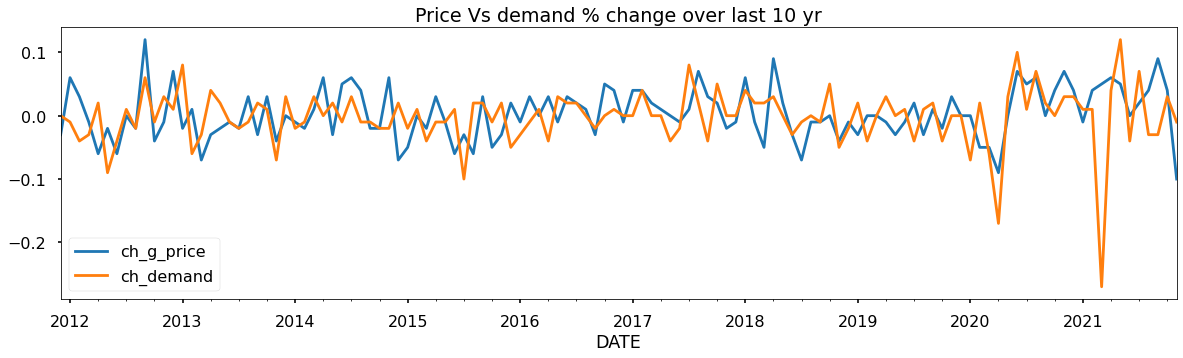

In [710]:
al[['ch_g_price', 'ch_demand']][-120:].plot(figsize=(20,5),title='Price Vs demand % change over last 10 yr')

In [711]:
al[['ch_g_price', 'ch_demand']][-60:].describe()  

,ch_g_price,ch_demand
count,60.000000,60.000000
mean,0.008000,0.000167
std,0.040789,0.056041
min,-0.100000,-0.270000
25%,-0.010000,-0.020000
50%,0.000000,-0.000000
75%,0.040000,0.030000
max,0.090000,0.120000


In [712]:
al[['ch_g_price', 'ch_demand']][-60:].corr()                                #Last 5 year's correlation

,ch_g_price,ch_demand
ch_g_price,1.000000,0.278943
ch_demand,0.278943,1.000000


In [713]:
al.describe()

,g_price,prod,inv,demand,PPI,ch_g_price,ch_prod,ch_inv,ch_demand,ch_PPI
count,323.000000,323.000000,323.000000,323.00000,323.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,1853.074303,99.167183,10478.715170,7368.06192,173.034056,0.001801,0.001304,0.001149,0.001242,0.001584
std,420.121116,8.823137,2269.167345,1636.82613,21.929349,0.046549,0.049680,0.017727,0.044599,0.018720
min,1179.000000,61.000000,6906.000000,4650.00000,139.000000,-0.190000,-0.230000,-0.180000,-0.270000,-0.100000
25%,1530.500000,95.000000,8291.000000,5867.50000,153.000000,-0.030000,-0.030000,-0.010000,-0.020000,-0.010000
50%,1773.000000,101.000000,11168.000000,7457.00000,173.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2061.500000,105.000000,12645.000000,8856.50000,187.000000,0.030000,0.030000,0.010000,0.030000,0.010000
max,3067.000000,119.000000,13680.000000,10739.00000,255.000000,0.150000,0.210000,0.060000,0.140000,0.060000


In [714]:
al_over_yr=al[['ch_g_price', 'ch_prod','ch_inv', 'ch_demand', 'ch_PPI']]

Text(0.5, 1.0, 'Box plot for % Change 1995-2021')

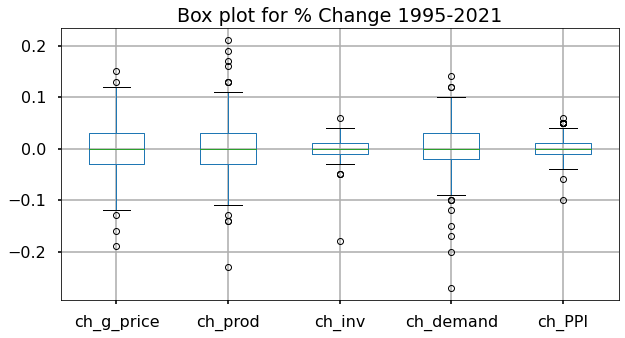

In [715]:
al_over_yr.boxplot(figsize=(10,5))
plt.title('Box plot for % Change 1995-2021')

In [716]:
logged= np.log(al)

# Corelation study

Text(0.5, 1.0, 'heatmap for change - after outlier removals')

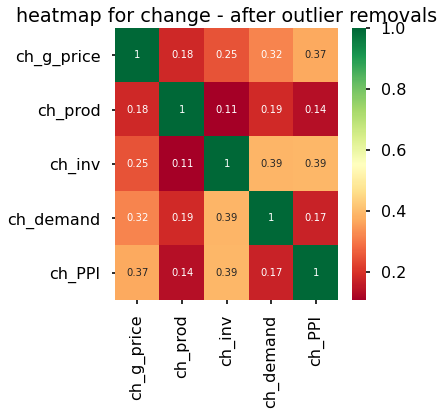

In [717]:
corrmat=al[['ch_g_price', 'ch_prod','ch_inv', 'ch_demand', 'ch_PPI']].corr()
top_corr= corrmat.index
plt.figure(figsize=(5,5))
g= sns.heatmap(al[top_corr].corr(), annot=True, cmap='RdYlGn')
plt.title('heatmap for change - after outlier removals')

# 4. Feature Selection using Granger Causality

In [718]:
import statsmodels as sm
from statsmodels.tsa.stattools import grangercausalitytests

In [893]:
al_granger= al[['g_price','PPI']]
grangercausalitytests(al_granger, maxlag=24)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2103  , p=0.0410  , df_denom=319, df_num=1
ssr based chi2 test:   chi2=4.2499  , p=0.0393  , df=1
likelihood ratio test: chi2=4.2221  , p=0.0399  , df=1
parameter F test:         F=4.2103  , p=0.0410  , df_denom=319, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7610  , p=0.4681  , df_denom=316, df_num=2
ssr based chi2 test:   chi2=1.5460  , p=0.4616  , df=2
likelihood ratio test: chi2=1.5423  , p=0.4625  , df=2
parameter F test:         F=0.7610  , p=0.4681  , df_denom=316, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4292  , p=0.0653  , df_denom=313, df_num=3
ssr based chi2 test:   chi2=7.4506  , p=0.0588  , df=3
likelihood ratio test: chi2=7.3652  , p=0.0611  , df=3
parameter F test:         F=2.4292  , p=0.0653  , df_denom=313, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6559  , p=0.1601  

{1: ({'ssr_ftest': (4.210320686874202, 0.04099469789754749, 319.0, 1),
   'ssr_chi2test': (4.2499161792272515, 0.0392522677937919, 1),
   'lrtest': (4.2221142869184405, 0.03990041309627837, 1),
   'params_ftest': (4.210320686874266, 0.04099469789754532, 319.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.7609778473738563, 0.4680635715652697, 316.0, 2),
   'ssr_chi2test': (1.546037272196252, 0.46161750775377186, 2),
   'lrtest': (1.542326081970259, 0.46247487816539623, 2),
   'params_ftest': (0.7609778473739264, 0.4680635715652284, 316.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.429198178092451, 0.06533659262180538, 313.0, 3),
   'ssr_chi2test': (7.450575881689306, 0.05884206082638042, 3),
   'lrtest': (7.36516305747773, 0.06112610702134254, 3),
   'params_ftest': (2.429198178092675, 0.06533659262178551, 313.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 

In [883]:
#al_granger= al[['g_price','prod']]
#grangercausalitytests(al_granger, maxlag=48)

In [884]:
#al_log_granger= logged[['g_price','PPI']]
#grangercausalitytests(al_log_granger, maxlag=48)

In [885]:
#al_log_granger= logged[['g_price','inv']]
#grangercausalitytests(al_log_granger, maxlag=48)

In [886]:
#al_log_granger2= logged[['demand', 'g_price']]
#grangercausalitytests(al_log_granger2, maxlag=48)

In [724]:
adfuller(al['ch_prod'][1:])             #Prod is stationary at 5%, Change in Prod is also Stationary

(-5.815129075314795,
 4.3102193919233116e-07,
 11,
 310,
 {'1%': -3.451621854687657,
  '5%': -2.870908950689806,
  '10%': -2.571761810613944},
 -1006.2130925405495)

In [887]:
#al_granger= al[['ch_g_price','ch_PPI']][2:]
#grangercausalitytests(al_granger, maxlag=24)

In [888]:
#al_granger= al[['ch_g_price','ch_inv']][2:]
#grangercausalitytests(al_granger, maxlag=24)

# 5. Time series estimation

<AxesSubplot:xlabel='DATE'>

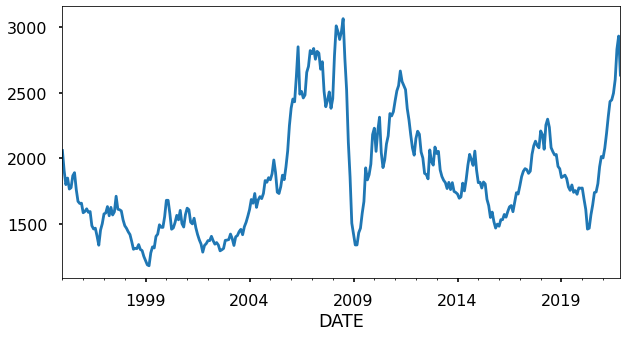

In [727]:
al['g_price'].plot(figsize=(10,5))

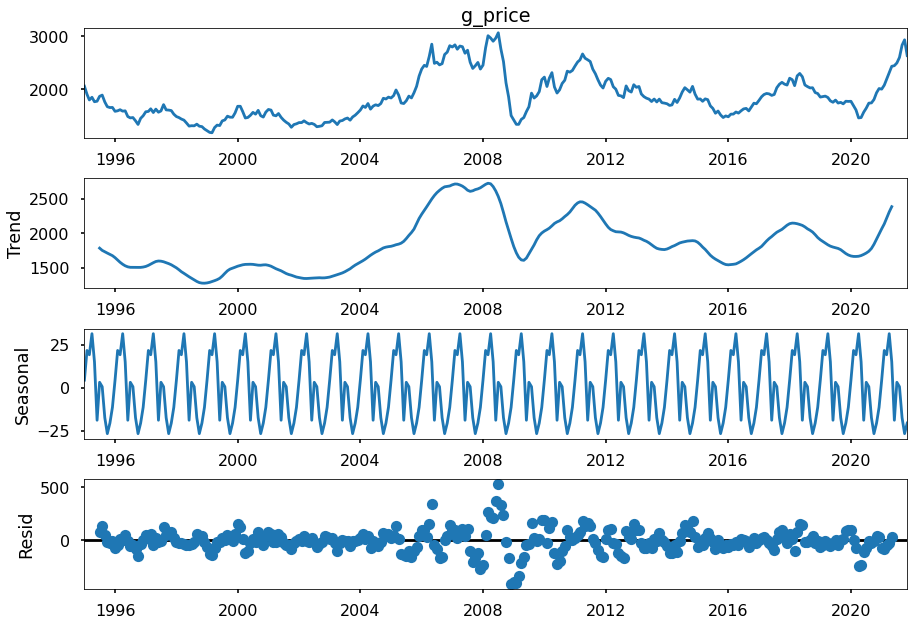

In [731]:
sm.tsa.seasonal.seasonal_decompose(al['g_price']).plot()
plt.tight_layout()

In [732]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
#result = adfuller(al['g_price'])
#print('ADF Statistic: %f' % result[0])
print('p-value of ad-fuller test for g_price: %f' % adfuller(al['g_price'])[1])
print('p-value of ad-fuller test for PPI: %f' % adfuller(al['PPI'])[1])
print('p-value of ad-fuller test for Inventory: %f' % adfuller(al['inv'])[1])
print('p-value of ad-fuller test for Demand: %f' % adfuller(al['demand'])[1])
print('p-value of ad-fuller test for Production: %f' % adfuller(al['prod'])[1])



p-value of ad-fuller test for g_price: 0.099884
p-value of ad-fuller test for PPI: 0.756934
p-value of ad-fuller test for Inventory: 0.532088
p-value of ad-fuller test for Demand: 0.269206
p-value of ad-fuller test for Production: 0.046044


# Models evaluated:
    a. ARIMA
    b. ARIMAX
    c. SARIMA
    d. VARMA
    e. LightGBM
    f. Linear regression with systematic sampling

# a. Auto ARIMA

In [733]:
from statsmodels.tsa.arima_model import ARMA, ARIMA

In [734]:
price_model=pm.auto_arima(al['g_price'],m=6,trace=True, suppress_warnings=True )
price_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=3828.306, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=3846.555, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=3823.776, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=3824.825, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=3844.671, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[6] intercept   : AIC=3826.864, Time=0.11 sec
 ARIMA(1,1,0)(2,0,0)[6] intercept   : AIC=3825.152, Time=0.27 sec
 ARIMA(1,1,0)(1,0,1)[6] intercept   : AIC=3825.228, Time=0.30 sec
 ARIMA(1,1,0)(0,0,1)[6] intercept   : AIC=3823.447, Time=0.20 sec
 ARIMA(1,1,0)(0,0,2)[6] intercept   : AIC=3825.279, Time=0.22 sec
 ARIMA(1,1,0)(1,0,2)[6] intercept   : AIC=3823.523, Time=0.53 sec
 ARIMA(0,1,0)(0,0,1)[6] intercept   : AIC=3842.037, Time=0.15 sec
 ARIMA(2,1,0)(0,0,1)[6] intercept   : AIC=3825.249, Time=0.22 sec
 ARIMA(1,1,1)(0,0,1)[6] intercept   : AIC=3824.203, Time=0.35 sec
 ARIMA(2,1,1)(0,0,1)[6] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  323
Model:             SARIMAX(1, 1, 0)x(0, 0, [1], 6)   Log Likelihood               -1907.751
Date:                             Mon, 05 Sep 2022   AIC                           3821.501
Time:                                     11:32:26   BIC                           3832.825
Sample:                                          0   HQIC                          3826.022
                                             - 323                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2541      0.039      6.595      0.000       0.179       0.330
ma.S.L6       -0.1369      0.049     -2.798      0.005      -0.233      -0.041
sigma2      8186.6117    471.176     17.375      0.000    7263.124    9110.099
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                92.21
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                            -0.59
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [735]:
price_model=pm.auto_arima(al['g_price'],m=12,trace=True, suppress_warnings=True )
price_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3831.396, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3846.555, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3828.653, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3829.506, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3844.671, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3826.864, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3828.477, Time=0.19 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3827.358, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=3828.818, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=3828.602, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3827.966, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=3830.864, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=3824.901, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=3826.676, Time=0.07 sec
 ARIMA(1,1,0)(0,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  323
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1910.451
Date:                Mon, 05 Sep 2022   AIC                           3824.901
Time:                        11:32:30   BIC                           3832.450
Sample:                             0   HQIC                          3827.915
                                - 323                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2604      0.037      6.983      0.000       0.187       0.333
sigma2      8286.3276    421.843     19.643      0.000    7459.531    9113.124
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               133.24
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.77   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# ARIMA 

**For 'change in price'**

In [736]:
size= int(al.shape[0]*.2)
size

64

In [737]:
order_model= ARIMA(al['ch_g_price'][1:], order=(6,0,1))      #Used change in price dataset
order_model_fit=order_model.fit()
order_model_fit.aic

-1076.53636532075

In [738]:
order_model= ARIMA(al['ch_g_price'][1:], order=(6,0,4))
order_model_fit=order_model.fit()
order_model_fit.aic

-1075.5409284137054

In [739]:
size= int(al['ch_g_price'][1:].shape[0]*0.2)

In [740]:
train, test = al['ch_g_price'][1:-size], al['ch_g_price'][-size:]
model_arima_604 = ARIMA(train, order=(6,0,4))
results_AR = model_arima_604.fit(disp=-1)

predict = model_arima_604.predict(test, start='2018-08-01', end='2021-11-01')

In [741]:
predictions= pd.DataFrame(predict, index= test.index, columns= ['Predictions'])

In [742]:
from sklearn.metrics import mean_squared_error

In [743]:
predictions= pd.DataFrame(predict, index= test.index, columns= ['Predictions'])

from sklearn.metrics import r2_score, mean_squared_error
rmse = np.sqrt(mean_squared_error(test,predict))
r2_score= r2_score(test, predict)
print('r2_score: ',r2_score)

print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
#plt.plot(test)
#plt.plot(predictions, color='red')
#plt.show()


r2_score:  -0.007943046488558814
Test RMSE: 0.040


**ARIMA for log price**

In [744]:
order_model= ARIMA(logged['g_price'][1:], order=(6,0,1))      #Used change in price dataset
order_model_fit=order_model.fit()
order_model_fit.aic

-1079.1871328187135

In [745]:
order_model= ARIMA(logged['g_price'], order=(2,0,1))      #Used change in price dataset
order_model_fit=order_model.fit()
order_model_fit.aic

-1082.4694333577918

In [749]:
size= 40
train, test= logged['g_price'][1:-size], logged['g_price'][-size:]
order_model1= ARIMA(train, order=(2,0,1))
order_model_fit1=order_model1.fit()
order_model_fit1.aic

predict1= order_model_fit1.predict(start='2018-08-01 ', end='2021-11-01 ')     #Tried exog=al_change['ch_g_price'][-size:]

Plotting ARIMA model


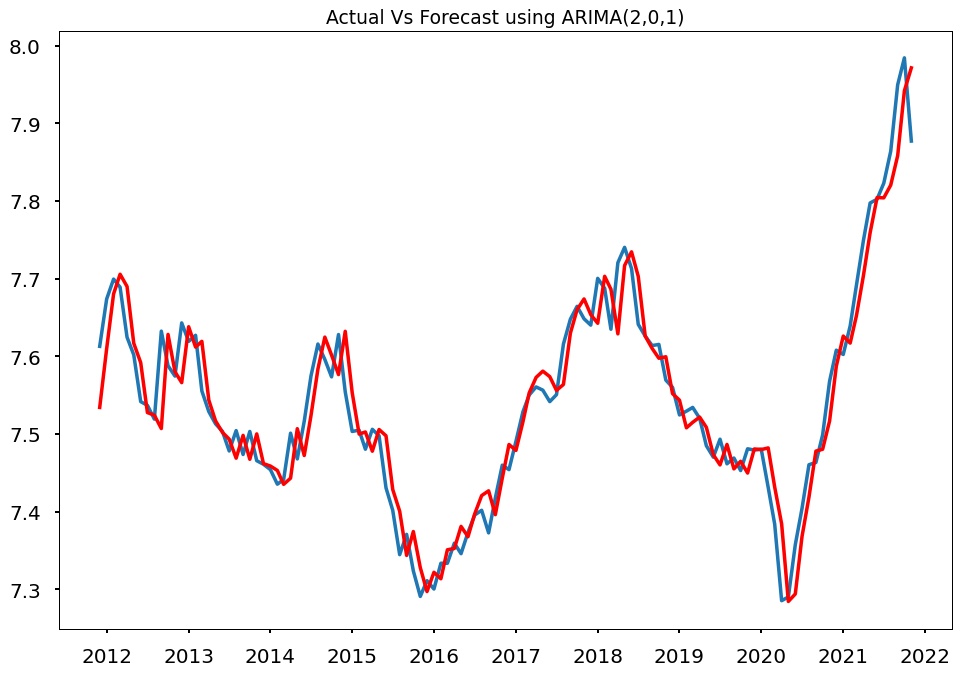

In [750]:
model = ARIMA(logged['g_price'][-120:], order=(2,0,1))
results_AR = model.fit(disp=-1)

plt.figure( dpi=90)
plt.plot(logged['g_price'][-120:])
plt.plot(results_AR.fittedvalues, color='red')
plt.title('Actual Vs Forecast using ARIMA(2,0,1)', fontsize=15)

print('Plotting ARIMA model')

In [751]:
from sklearn.metrics import r2_score
aic= order_model_fit1.aic
rmse = np.sqrt(mean_squared_error(np.exp(test), np.exp(predict1)))
#rmsle = np.sqrt(mean_squared_error(test, res_sarimax))
r2_score= r2_score(np.exp(test), np.exp(predict1))
MAPE= mean_absolute_percentage_error(np.exp(test), np.exp(predict1))*100

print('aic: %.3f' % aic)
print('r2_score: %.3f' % r2_score)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % MAPE)
#print('Test Log RMSE: %.3f' % rmsle)

aic: -935.803
r2_score: -0.184
RMSE: 384.989
MAPE: 11.964


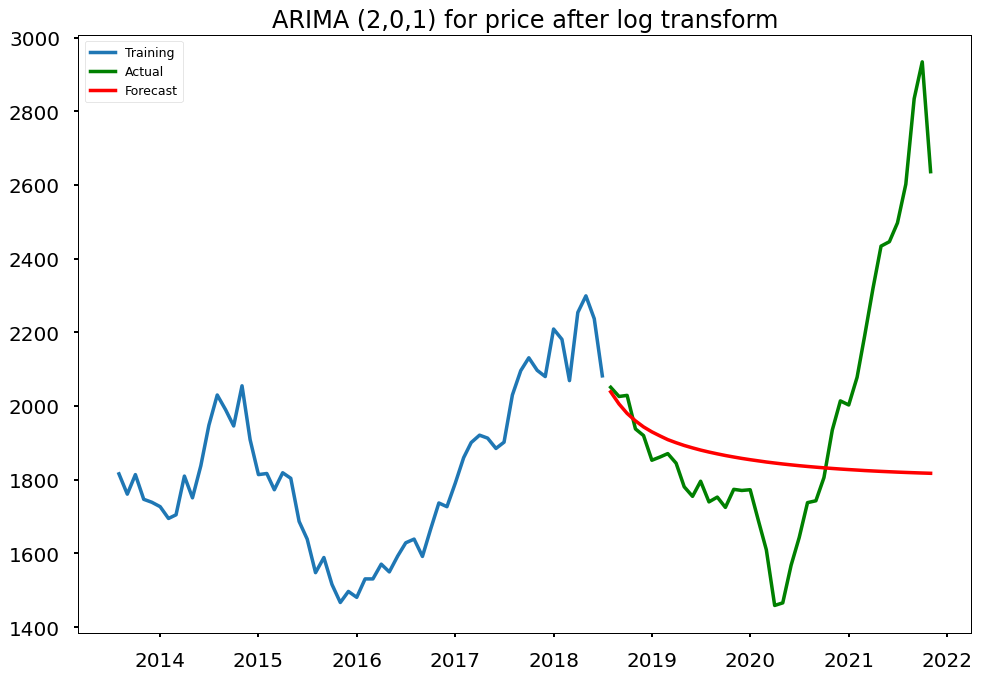

In [752]:
#plot forecasts against actual outcomes
plt.figure( dpi=90)
plt.plot(np.exp(train[-60:]), label='Training')
plt.plot(np.exp(test), label='Actual', color= 'green')
plt.plot(np.exp(predict1), color='red', label= 'Forecast')
plt.title('ARIMA (2,0,1) for price after log transform')
plt.legend(loc='upper left', fontsize=10)
plt.show()

# b. ARIMAX with log data

In [753]:
size=int(logged.shape[0]*0.2)          
train, test= logged['g_price'][:-size], logged['g_price'][-size:]

In [754]:
test

DATE
2016-08-01    7.401842
2016-09-01    7.372746
2016-10-01    7.417580
2016-11-01    7.459915
2016-12-01    7.454141
                ...   
2021-07-01    7.822845
2021-08-01    7.864036
2021-09-01    7.949444
2021-10-01    7.984122
2021-11-01    7.877018
Name: g_price, Length: 64, dtype: float64

In [755]:
 #Random sampling with 20% test data, order = (1,0,1) and (1,0,2)
size=int(logged.shape[0]*0.2)

train, test= logged['g_price'][:-size], logged['g_price'][-size:]
order_model1= ARIMA(train ,exog=logged['PPI'][:-size] , order=(1,0,1))
order_model_fit1=order_model1.fit()
order_model_fit1.aic

predict1= order_model_fit1.predict(start='2016-08-01 ', end='2021-11-01 ', exog= logged['PPI'][-size:])     #Tried exog=al_change['ch_g_price'][-size:]

In [756]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
rmse = np.sqrt(mean_squared_error(np.exp(test), np.exp(predict1)))
r2_score= r2_score(np.exp(test), np.exp(predict1))

print('r2_score: %.3f' % r2_score)
print('Test RMSE: %.3f' % rmse)
print(f'MAPE: %.3f' % (mean_absolute_percentage_error(np.exp(test), np.exp(predict1))*100))


r2_score: 0.539
Test RMSE: 207.755
MAPE: 9.032


In [757]:
 #Random sampling with 20% test data, order = (2,0,1) and (2,0,2)
size=int(logged.shape[0]*0.2)

train, test= logged['g_price'][:-size], logged['g_price'][-size:]
order_model2= ARIMA(train ,exog=logged['PPI'][:-size] , order=(2,0,1))
order_model_fit2=order_model2.fit()
order_model_fit2.aic

predict2= order_model_fit2.predict(start='2016-08-01 ', end='2021-11-01 ', exog= logged['PPI'][-size:])     #Tried exog=al_change['ch_g_price'][-size:]

In [758]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
rmse = np.sqrt(mean_squared_error(np.exp(test), np.exp(predict2)))
r2_score= r2_score(np.exp(test), np.exp(predict2))

print('r2_score: %.3f' % r2_score)
print('Test RMSE: %.3f' % rmse)
print(f'MAPE: %.3f' % (mean_absolute_percentage_error(np.exp(test), np.exp(predict2))*100))


r2_score: 0.539
Test RMSE: 207.737
MAPE: 8.978


In [759]:
40/323

0.1238390092879257

In [760]:
#Random sampling with 12% test data
size=int(logged.shape[0]*0.12)   

train, test= logged['g_price'][1:-size], logged['g_price'][-size:]
order_model1= ARIMA(train ,exog=logged['PPI'][1:-size] , order=(2,0,1))
order_model_fit1=order_model1.fit()
order_model_fit1.aic

predict1= order_model_fit1.predict(start='2018-10-01 ', end='2021-11-01 ', exog= logged['PPI'][-size:])     #Tried exog=al_change['ch_g_price'][-size:]

In [895]:
#test

r2_score: 0.713
Test RMSE: 194.103
MAPE: 9.169


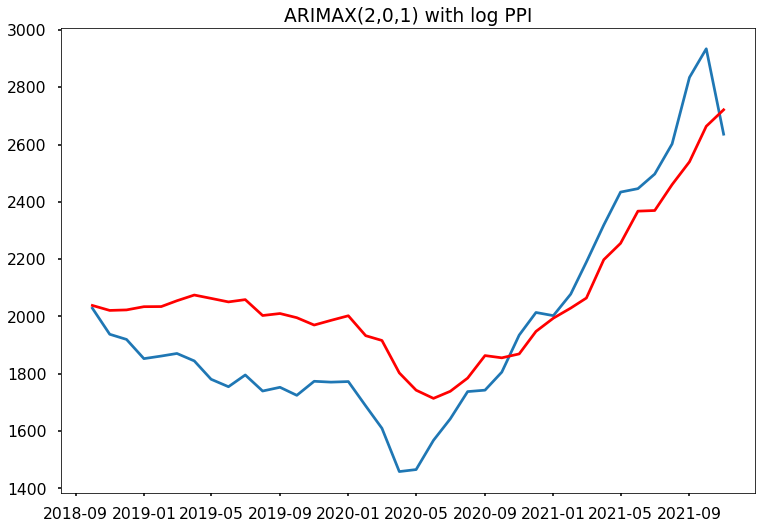

In [762]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
rmse = np.sqrt(mean_squared_error(np.exp(test), np.exp(predict1)))
r2_score= r2_score(np.exp(test), np.exp(predict1))

print('r2_score: %.3f' % r2_score)
print('Test RMSE: %.3f' % rmse)
print(f'MAPE: %.3f' % (mean_absolute_percentage_error(np.exp(test), np.exp(predict1))*100))
# plot forecasts against actual outcomes

plt.figure( dpi=70)
plt.plot(np.exp(test))
plt.plot(np.exp(predict1), color='red')
plt.title('ARIMAX(2,0,1) with log PPI')

plt.show()

# c. SARIMAX for Price

In [763]:
import statsmodels.api as sm

In [764]:
scaled.columns

Index(['g_price', 'prod', 'inv', 'demand', 'PPI'], dtype='object')

<AxesSubplot:xlabel='DATE'>

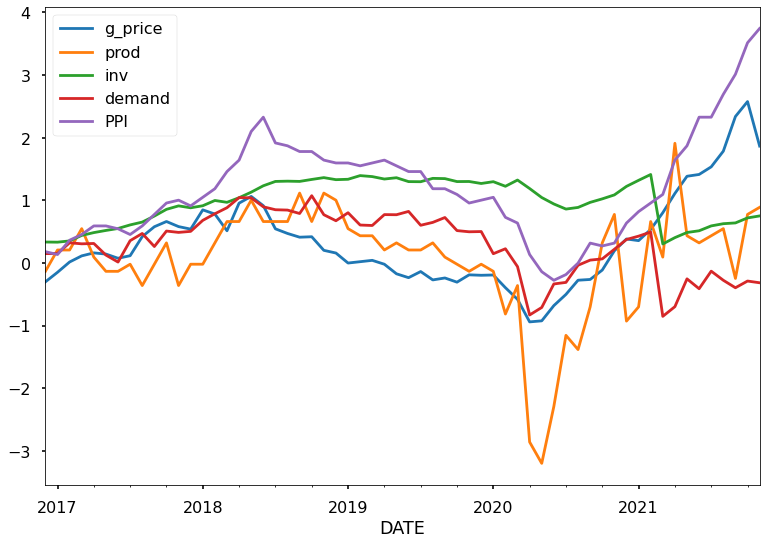

In [765]:
scaled[-60:].plot()

In [766]:
logged= np.log(al)

In [767]:
adfuller(logged['g_price'])               #Even Scaler prices are NOT Stationary but log is stationary with alpha=0.05

(-2.998244093268428,
 0.035058705570125484,
 4,
 318,
 {'1%': -3.451082300831733,
  '5%': -2.87067210822307,
  '10%': -2.5716355136268345},
 -1024.3206368878898)

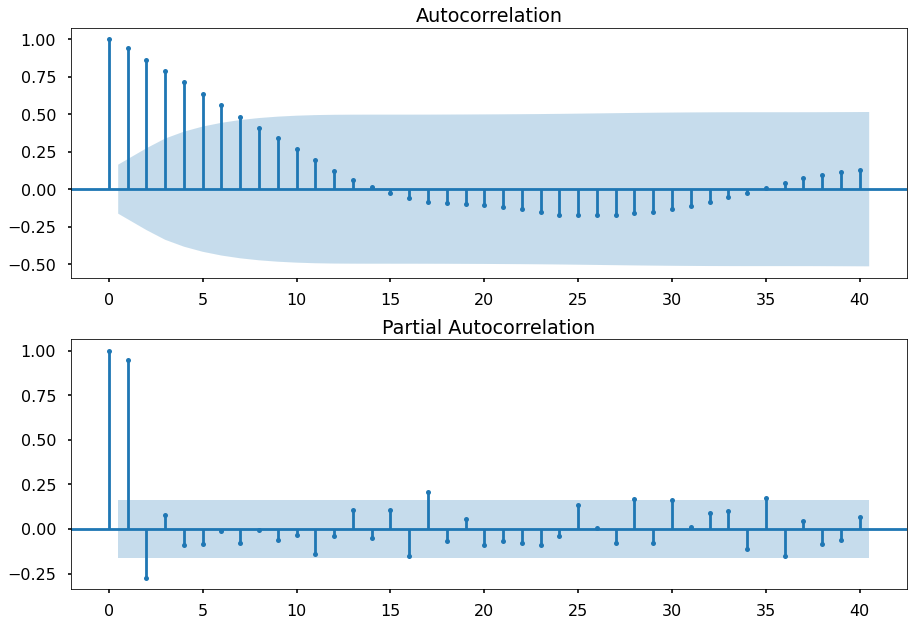

In [772]:
ax = plt.subplot(211)

import statsmodels.api as sm
sm.tsa.graphics.plot_acf(logged['g_price'][-144:].values.squeeze(), lags=40, ax=ax)


ax = plt.subplot(212)
sm.tsa.graphics.plot_pacf(logged['g_price'][-144:].values.squeeze(), lags=40, ax=ax)
plt.tight_layout()
plt.show()

From above plots, p= (1,2,17,36), q= (1,2)

In [773]:
#sm.tsa.seasonal_decompose(scaled['g_price']).plot()
#plt.tight_layout()

In [774]:
size= int(logged.shape[0]*0.20)
size

64

In [775]:
train, test= logged['g_price'][0:-size], logged['g_price'][-size:]

In [776]:
test

DATE
2016-08-01    7.401842
2016-09-01    7.372746
2016-10-01    7.417580
2016-11-01    7.459915
2016-12-01    7.454141
                ...   
2021-07-01    7.822845
2021-08-01    7.864036
2021-09-01    7.949444
2021-10-01    7.984122
2021-11-01    7.877018
Name: g_price, Length: 64, dtype: float64

In [777]:
sarimax_model= sm.tsa.statespace.SARIMAX(train, exog= logged['PPI'][:-size], order=(2,0,1), seasonal_order=(1,0,0,12), enforce_stationarity=True)
fit_sarimax= sarimax_model.fit()
res_sarimax= fit_sarimax.predict(start='2016-08-01 ', end='2021-11-01 ',exog=logged['PPI'][-size:])

In [778]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
aic= fit_sarimax.aic
rmse = np.sqrt(mean_squared_error(np.exp(test), np.exp(res_sarimax)))
#rmsle = np.sqrt(mean_squared_error(test, res_sarimax))
r2_score= r2_score(np.exp(test), np.exp(res_sarimax))
MAPE= mean_absolute_percentage_error(np.exp(test), np.exp(res_sarimax))*100

print('aic: %.3f' % aic)
print('r2_score: %.3f' % r2_score)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % MAPE)
#print('Test Log RMSE: %.3f' % rmsle)

aic: -856.853
r2_score: -0.295
RMSE: 348.065
MAPE: 14.307


In [779]:
sarimax_model= sm.tsa.statespace.SARIMAX(train, exog= logged['PPI'][:-size], order=(2,0,2), seasonal_order=(1,0,0,12), enforce_stationarity=True)
fit_sarimax= sarimax_model.fit()
res_sarimax= fit_sarimax.predict(start='2016-08-01', end='2021-11-01',exog=logged['PPI'][-size:])

In [780]:
from sklearn.metrics import r2_score
aic= fit_sarimax.aic
rmse = np.sqrt(mean_squared_error(np.exp(test), np.exp(res_sarimax)))
#rmsle = np.sqrt(mean_squared_error(test, res_sarimax))
r2_score= r2_score(np.exp(test), np.exp(res_sarimax))
MAPE= mean_absolute_percentage_error(np.exp(test), np.exp(res_sarimax))*100

print('aic: %.3f' % aic)
print('r2_score: %.3f' % r2_score)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % MAPE)
#print('Test Log RMSE: %.3f' % rmsle)

aic: -855.678
r2_score: 0.000
RMSE: 305.852
MAPE: 12.385


In [781]:
sarimax_model= sm.tsa.statespace.SARIMAX(train, exog= logged['PPI'][:-size], order=(1,0,1), seasonal_order=(0,0,0,12), enforce_stationarity=True)
fit_sarimax= sarimax_model.fit()
res_sarimax= fit_sarimax.predict(start='2016-08-01 ', end='2021-11-01 ',exog=logged['PPI'][-size:])

In [782]:
from sklearn.metrics import r2_score
aic= fit_sarimax.aic
rmse = np.sqrt(mean_squared_error(np.exp(test), np.exp(res_sarimax)))
#rmsle = np.sqrt(mean_squared_error(test, res_sarimax))
r2_score= r2_score(np.exp(test), np.exp(res_sarimax))
MAPE= mean_absolute_percentage_error(np.exp(test), np.exp(res_sarimax))*100

print('aic: %.3f' % aic)
print('r2_score: %.3f' % r2_score)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % MAPE)
#print('Test Log RMSE: %.3f' % rmsle)

aic: -860.698
r2_score: -0.303
RMSE: 349.194
MAPE: 14.379


In [783]:
sarimax_model= sm.tsa.statespace.SARIMAX(train, exog= logged['PPI'][:-size], order=(1,1,1), seasonal_order=(0,0,0,12))
fit_sarimax= sarimax_model.fit()
res_sarimax= fit_sarimax.predict(start='2016-08-01 ', end='2021-11-01 ',exog=logged['PPI'][-size:])

In [784]:
from sklearn.metrics import r2_score
aic= fit_sarimax.aic
rmse = np.sqrt(mean_squared_error(np.exp(test), np.exp(res_sarimax)))
#rmsle = np.sqrt(mean_squared_error(test, res_sarimax))
r2_score= r2_score(np.exp(test), np.exp(res_sarimax))
MAPE= mean_absolute_percentage_error(np.exp(test), np.exp(res_sarimax))*100

print('aic: %.3f' % aic)
print('r2_score: %.3f' % r2_score)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % MAPE)
#print('Test Log RMSE: %.3f' % rmsle)

#plt.plot(test)
#plt.plot(res_sarimax, color='red')
#plt.title('SARIMAX for price, exog= PPI, order= (6,1,1)(0,0,0,12)')
#plt.show()

aic: -860.568
r2_score: 0.420
RMSE: 232.974
MAPE: 8.679


In [785]:
logged.reset_index()

,DATE,g_price,prod,inv,demand,PPI,ch_g_price,ch_prod,ch_inv,ch_demand,ch_PPI
0,1995-01-01,7.629976,4.615121,9.051931,8.733916,5.087596,NaN,NaN,NaN,NaN,NaN
1,1995-02-01,7.552237,4.605170,9.063579,8.689464,5.135798,NaN,NaN,-4.605170,NaN,-2.995732
2,1995-03-01,7.494986,4.574711,9.072457,8.705662,5.159055,NaN,NaN,-4.605170,-3.912023,-3.912023
3,1995-04-01,7.522400,4.605170,9.079434,8.728588,5.181784,-3.506558,-3.506558,-4.605170,-3.912023,-3.912023
4,1995-05-01,7.475906,4.564348,9.073833,8.665096,5.170484,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
318,2021-07-01,7.822845,4.634729,9.377633,8.875706,5.411646,-3.912023,-4.605170,-3.912023,-2.659260,-inf
319,2021-08-01,7.864036,4.644391,9.384378,8.841882,5.446737,-3.218876,-4.605170,-4.605170,NaN,-3.218876
320,2021-09-01,7.949444,4.574711,9.386728,8.813290,5.476464,-2.407946,NaN,-inf,NaN,-3.506558
321,2021-10-01,7.984122,4.663439,9.401787,8.838987,5.521461,-3.218876,-2.407946,-3.912023,-3.506558,-2.995732


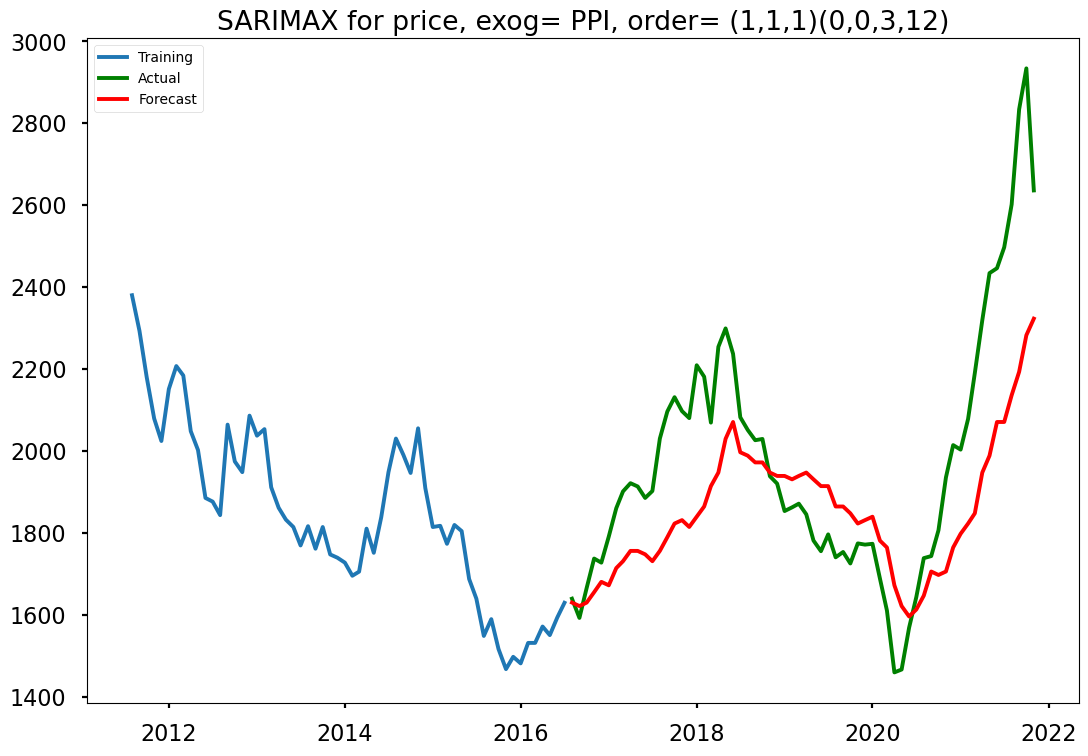

In [786]:
# plot forecasts against actual outcomes
plt.figure( dpi=100)
plt.plot(np.exp(train[-60:]), label='Training')
plt.plot(np.exp(test), label='Actual', color= 'green')
plt.plot(np.exp(res_sarimax), color='red', label= 'Forecast')
plt.title('SARIMAX for price, exog= PPI, order= (1,1,1)(0,0,3,12)')
plt.legend(loc='upper left', fontsize=10)
plt.show()

Text(0.5, 1.0, 'Residuals PDF')

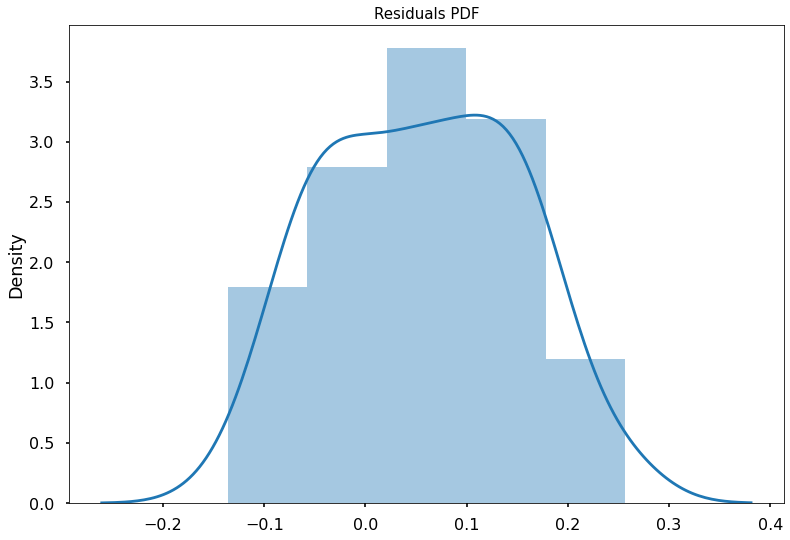

In [787]:
sns.distplot(test-res_sarimax)       #2. Plot the residuals. The error should follow- Normality (Mean=0, Homoscedasticity)
plt.title('Residuals PDF', size=15)

# d. VARMAX

In [788]:
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score

In [789]:
df=al[['ch_g_price', 'ch_inv', 'ch_PPI']][1:]

In [790]:
2858*240

685920

In [791]:
test.shape

(64,)

In [792]:
import statsmodels.api as sm

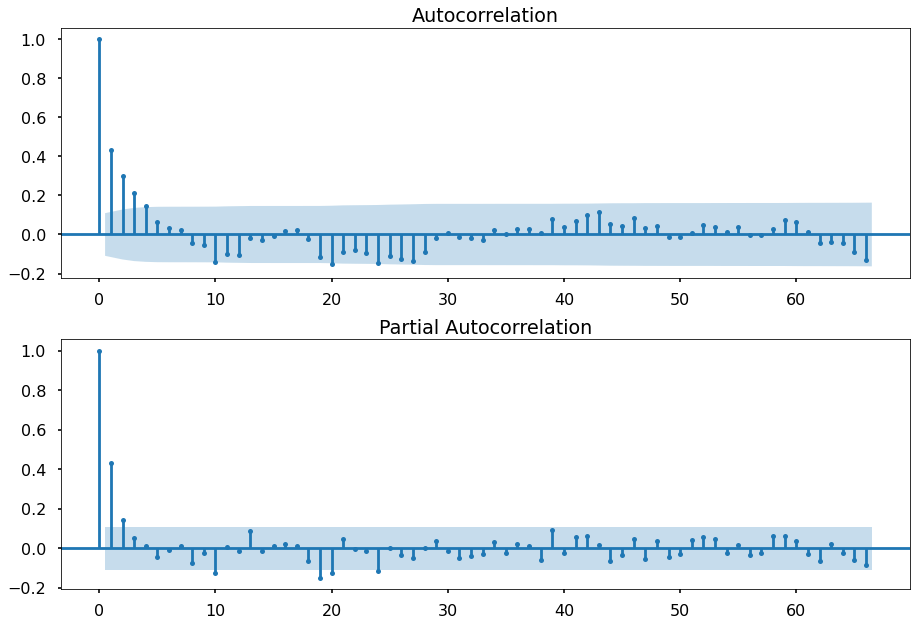

In [793]:
import statsmodels.api as sm
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['ch_PPI'].values.squeeze(), lags=66, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df['ch_PPI'].values.squeeze(), lags=66, ax=ax)
plt.tight_layout()
plt.show()

In [794]:
#Order for ch_PPI p= (1,10,19) and q= (1,2,3) 

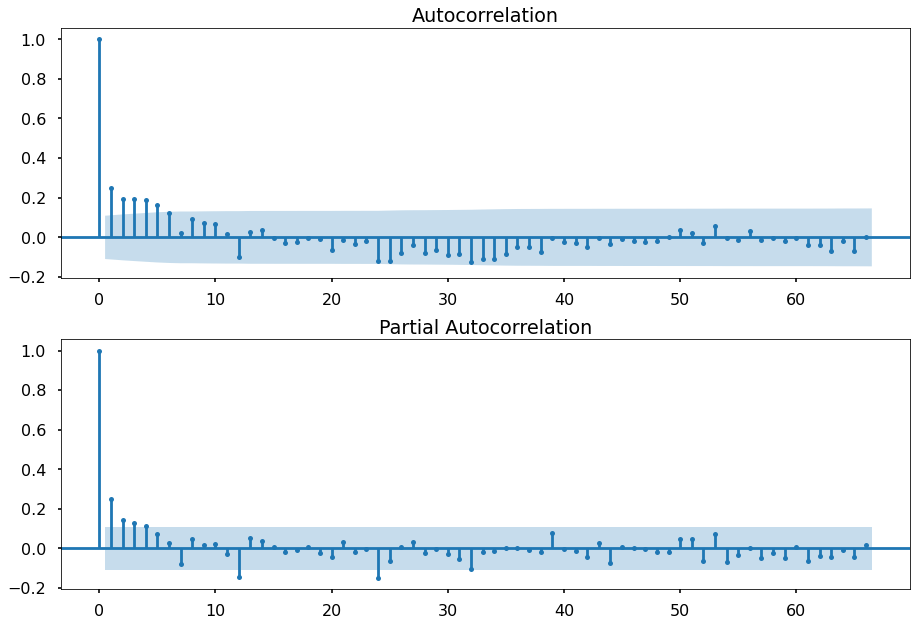

In [795]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['ch_inv'].values.squeeze(), lags=66, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df['ch_inv'].values.squeeze(),lags=66,ax=ax)
plt.tight_layout()
plt.show()

In [796]:
#Order for ch_inv p= (1,2,3,12, 24) and q= (1,2,3,4,5) 

<AxesSubplot:xlabel='DATE'>

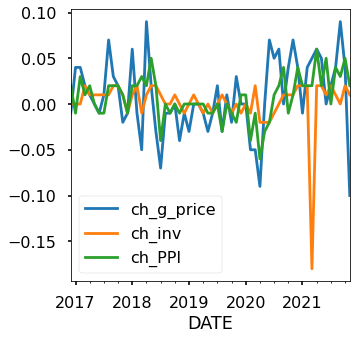

In [797]:
df[-60:].plot(figsize=(5,5))

In [798]:
df['ch_inv'][-60:].min()

-0.18

In [799]:
df['ch_inv']=np.where(df['ch_inv']<= -0.18, 0.03, df['ch_inv'])

In [800]:
df['ch_inv'][-60:].min()

-0.02

In [801]:
from statsmodels.tsa.api import VAR

In [802]:
ntest=int(df.shape[0]*0.2)
train_var= df[:-ntest]
test_var=df['2016-08-01':'2021-11-01 ']

In [803]:
selectorder = VAR(train_var[1:])

In [804]:
sorted_order=selectorder.select_order(maxlags=15)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -23.11      -23.06   9.216e-11      -23.09
1       -23.99     -23.82*   3.806e-11      -23.92
2       -24.04      -23.74   3.612e-11     -23.92*
3       -24.09      -23.66   3.452e-11      -23.92
4      -24.11*      -23.55  3.376e-11*      -23.89
5       -24.10      -23.41   3.405e-11      -23.82
6       -24.09      -23.27   3.456e-11      -23.76
7       -24.07      -23.12   3.530e-11      -23.69
8       -24.06      -22.98   3.575e-11      -23.62
9       -24.03      -22.81   3.692e-11      -23.54
10      -23.97      -22.63   3.892e-11      -23.43
11      -23.95      -22.48   4.005e-11      -23.35
12      -23.93      -22.33   4.082e-11      -23.28
13      -23.89      -22.16   4.254e-11      -23.19
14      -23.84      -21.98   4.482e-11      -23.09
15      -23.80      -21.81   4.676e-11      -23.00
-------------------------------

In [805]:
t0= datetime.now()

# VARMAX

**VARMAX- For change in each variable**

In [806]:
df2=al[['ch_g_price', 'ch_PPI', 'ch_inv']][1:]

In [807]:
ntest=int(df2.shape[0]*0.02)
train_var= df2[:-ntest]
test_var=df2[-ntest:]

In [808]:
ntest

6

In [809]:
model_varmax= VARMAX(train_var,order=(2,1))
res1=model_varmax.fit()
print('Duration: ', datetime.now()-t0)

Duration:  0:00:04.377676


In [810]:
#res1.plot_diagnostics()

In [811]:
predictions = res1.forecast(steps=ntest)

In [812]:
test_var

,ch_g_price,ch_PPI,ch_inv
DATE,,,
2021-06-01,0.00,0.05,0.01
2021-07-01,0.02,0.00,0.02
2021-08-01,0.04,0.04,0.01
2021-09-01,0.09,0.03,0.00
2021-10-01,0.04,0.05,0.02
2021-11-01,-0.10,0.02,0.01


In [813]:
from sklearn.metrics import r2_score
test_vs_pred=pd.concat([test_var,predictions],axis=1)
rmse = np.sqrt(mean_squared_error(test_var['ch_g_price'], predictions['ch_g_price']))
r2_score= r2_score(test_var['ch_g_price'], predictions['ch_g_price'])
print('r2_score: %.3f' % r2_score)
print('Test RMSE: %.3f' % rmse)


r2_score: -0.039
Test RMSE: 0.059


In [814]:
res1.summary()

Dep. Variable:,"['ch_g_price', 'ch_PPI', 'ch_inv']",No. Observations:,316
Model:,"VARMA(2,1)",Log Likelihood,2349.343
,+ intercept,AIC,-4626.687
Date:,"Mon, 05 Sep 2022",BIC,-4491.480
Time:,11:39:57,HQIC,-4572.673
Sample:,02-01-1995,,
,- 05-01-2021,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.01, 0.25, 0.01",Jarque-Bera (JB):,"4.54, 27.19, 73314.12"
Prob(Q):,"0.94, 0.62, 0.94",Prob(JB):,"0.10, 0.00, 0.00"
Heteroskedasticity (H):,"1.00, 1.21, 4.24",Skew:,"-0.13, 0.12, -5.99"


p_values for any of the co-efficients are NOT significant. Only error terms are significant.

In [815]:
model_varmax= VARMAX(train_var,order=(2,0))
res2=model_varmax.fit()
print('Duration: ', datetime.now()-t0)

Duration:  0:00:06.166567


In [889]:
#res2.summary()

In [817]:
predictions = res2.forecast(steps=ntest)


In [818]:
predictions = res2.forecast(steps=ntest)


from sklearn.metrics import r2_score
rmse = np.sqrt(mean_squared_error(test_var['ch_g_price'], predictions['ch_g_price']))
r2_score= r2_score(test_var['ch_g_price'], predictions['ch_g_price'])
print('r2_score: %.3f' % r2_score)
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
#plt.plot(test_var)
#plt.plot(predictions, color='red')
#plt.show()

r2_score: -0.054
Test RMSE: 0.060


In [819]:
model_varmax= VARMAX(train_var,order=(2,3))
res2=model_varmax.fit()
print('Duration: ', datetime.now()-t0)

Duration:  0:00:12.461994


r2_score: -0.054
Test RMSE: 0.060


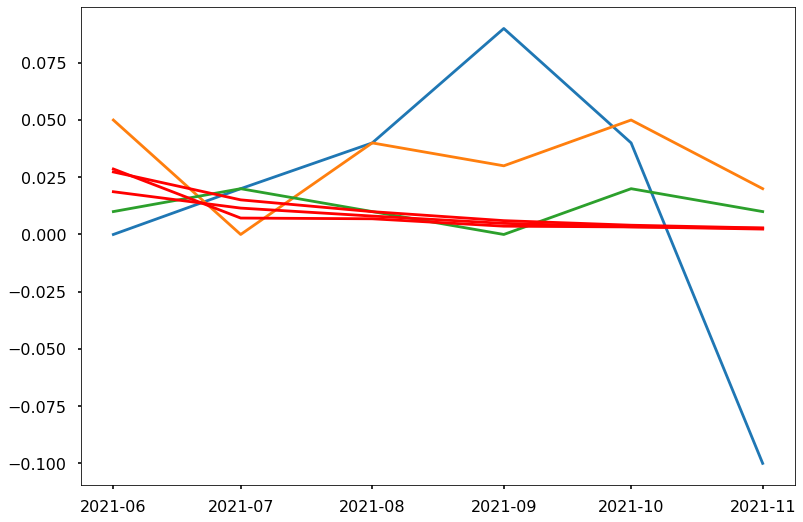

In [820]:
from sklearn.metrics import r2_score
rmse = np.sqrt(mean_squared_error(test_var['ch_g_price'], predictions['ch_g_price']))
r2_score= r2_score(test_var['ch_g_price'], predictions['ch_g_price'])
print('r2_score: %.3f' % r2_score)
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.plot(test_var)
plt.plot(predictions, color='red')
plt.show()

In [891]:
#res7.summary()

In [822]:
df2=al[['ch_g_price', 'ch_PPI']][1:]

In [823]:
ntest=int(df2.shape[0]*0.02)
train_var= df2[:-ntest]
test_var=df2[-ntest:]

In [824]:
model_varmax= VARMAX(train_var,order=(2,1))
res8=model_varmax.fit()
print('Duration: ', datetime.now()-t0)

Duration:  0:00:14.658672


In [825]:

predictions = res8.forecast(steps=ntest)

#predictions=predict.predicted_mean  --> if you use res8.get_prediction()


from sklearn.metrics import r2_score
rmse = np.sqrt(mean_squared_error(test_var['ch_g_price'], predictions['ch_g_price']))
r2_score= r2_score(test_var['ch_g_price'], predictions['ch_g_price'])
print('r2_score: %.3f' % r2_score)
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
#plt.plot(test_var)
#plt.plot(predictions, color='red')
#plt.show()


r2_score: -0.061
Test RMSE: 0.060


In [890]:
#res8.summary()

**VARMAX- For log transformed data**

In [827]:
df3=logged[['g_price', 'PPI', 'inv']]
ntest=int(df3.shape[0]*0.02)
train_var= df3[:-ntest]
test_var=df3[-ntest:]

In [828]:
logged[['g_price', 'PPI', 'inv']].isnull().sum()

g_price    0
PPI        0
inv        0
dtype: int64

In [829]:
model_varmax= VARMAX(train_var,order=(2,1))
res7=model_varmax.fit()

In [892]:
#res7.summary()

In [831]:
test_var

,g_price,PPI,inv
DATE,,,
2021-06-01,7.802209,5.411646,9.362632
2021-07-01,7.822845,5.411646,9.377633
2021-08-01,7.864036,5.446737,9.384378
2021-09-01,7.949444,5.476464,9.386728
2021-10-01,7.984122,5.521461,9.401787
2021-11-01,7.877018,5.541264,9.407715


r2_score: -12.717
Test RMSE: 0.240


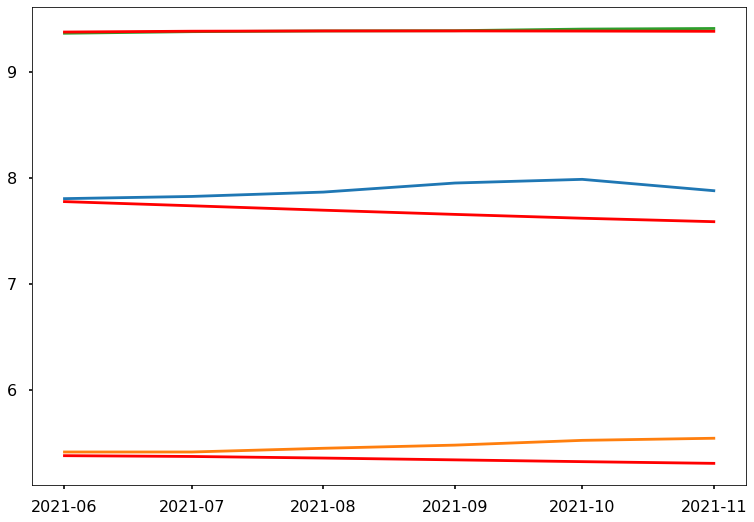

In [832]:

predictions = res7.forecast(steps=ntest)

#predictions=predict.predicted_mean  --> if you use res8.get_prediction()


from sklearn.metrics import r2_score
rmse = np.sqrt(mean_squared_error(test_var['g_price'], predictions['g_price']))
r2_score= r2_score(test_var['g_price'], predictions['g_price'])
print('r2_score: %.3f' % r2_score)
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.plot(test_var)
plt.plot(predictions, color='red')
plt.show()


In [833]:
predictions

,g_price,PPI,inv
2021-06-01,7.774150,5.376900,9.374119
2021-07-01,7.734732,5.369422,9.381893
2021-08-01,7.693061,5.354445,9.384519
2021-09-01,7.653477,5.337426,9.384571
2021-10-01,7.617271,5.320508,9.383209
2021-11-01,7.584679,5.304442,9.380945


# d.ii VECM


In [834]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.vector_ar.vecm import VECM
import pandas as pd

from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from statsmodels.tsa.vector_ar.vecm import select_order

In [835]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
#result = adfuller(al['g_price'])
#print('ADF Statistic: %f' % result[0])
print('p-value of ad-fuller test for g_price: %f' % adfuller(al['g_price'])[1])
print('p-value of ad-fuller test for PPI: %f' % adfuller(al['PPI'])[1])
print('p-value of ad-fuller test for Inventory: %f' % adfuller(al['inv'], maxlag=48)[1])
print('p-value of ad-fuller test for Demand: %f' % adfuller(al['demand'])[1])
print('p-value of ad-fuller test for Production: %f' % adfuller(al['prod'])[1])
print('p-value of ad-fuller test for Production: %f' % adfuller(al['g_price']-al['demand'])[1])

p-value of ad-fuller test for g_price: 0.099884
p-value of ad-fuller test for PPI: 0.756934
p-value of ad-fuller test for Inventory: 0.532088
p-value of ad-fuller test for Demand: 0.269206
p-value of ad-fuller test for Production: 0.046044
p-value of ad-fuller test for Production: 0.446653


In [836]:
al.columns

Index(['g_price', 'prod', 'inv', 'demand', 'PPI', 'ch_g_price', 'ch_prod',
       'ch_inv', 'ch_demand', 'ch_PPI'],
      dtype='object')

In [837]:
al_vecm= al[['g_price', 'demand','PPI']]

In [838]:
logged.tail(4)

,g_price,prod,inv,demand,PPI,ch_g_price,ch_prod,ch_inv,ch_demand,ch_PPI
DATE,,,,,,,,,,
2021-08-01,7.864036,4.644391,9.384378,8.841882,5.446737,-3.218876,-4.605170,-4.605170,NaN,-3.218876
2021-09-01,7.949444,4.574711,9.386728,8.813290,5.476464,-2.407946,NaN,-inf,NaN,-3.506558
2021-10-01,7.984122,4.663439,9.401787,8.838987,5.521461,-3.218876,-2.407946,-3.912023,-3.506558,-2.995732
2021-11-01,7.877018,4.672829,9.407715,8.832442,5.541264,NaN,-4.605170,-4.605170,NaN,-3.912023


In [839]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
#result = adfuller(al['g_price'])
#print('ADF Statistic: %f' % result[0])
print('p-value of ad-fuller test for logged g_price: %f' % adfuller(logged['g_price'])[1])
print('p-value of ad-fuller test for logged PPI: %f' % adfuller(logged['PPI'])[1])
print('p-value of ad-fuller test for logged Inventory: %f' % adfuller(logged['inv'])[1])
print('p-value of ad-fuller test for logged Demand: %f' % adfuller(logged['demand'])[1])
print('p-value of ad-fuller test for logged Production: %f' % adfuller(logged['prod'])[1])
print('p-value of ad-fuller test for logged spread: %f' % adfuller(logged['g_price']-logged['demand']-logged['PPI'])[1])

p-value of ad-fuller test for logged g_price: 0.035059
p-value of ad-fuller test for logged PPI: 0.647840
p-value of ad-fuller test for logged Inventory: 0.579458
p-value of ad-fuller test for logged Demand: 0.302530
p-value of ad-fuller test for logged Production: 0.044537
p-value of ad-fuller test for logged spread: 0.219274


# e. LightGBM

In [840]:
!pip install lightgbm

In [841]:
import lightgbm as ltb

In [842]:
al.columns

Index(['g_price', 'prod', 'inv', 'demand', 'PPI', 'ch_g_price', 'ch_prod',
       'ch_inv', 'ch_demand', 'ch_PPI'],
      dtype='object')

In [843]:
al.shape

(323, 10)

In [844]:
323*.8

258.40000000000003

In [845]:
x_train= scaled[['prod', 'inv', 'demand', 'PPI']][:-64]
y_train= scaled['g_price'][:-64]
x_test= scaled[['prod', 'inv', 'demand', 'PPI']][-64:]
y_test= scaled['g_price'][-64:]

In [846]:
y_test.shape

(64,)

In [847]:
model_lgbm = ltb.LGBMRegressor()

In [848]:
model_lgbm.fit(x_train, y_train)
print(model_lgbm)
    

LGBMRegressor()


In [849]:
expected_y=y_test
predicted_y = model_lgbm.predict(x_test)

In [850]:
from sklearn.metrics import r2_score

In [851]:
print('r2_score: %.2f'% r2_score(expected_y, predicted_y))
print('rmse %.2f'% np.sqrt(mean_squared_error(expected_y, predicted_y)))

r2_score: -0.74
rmse 0.96


<AxesSubplot:xlabel='g_price'>

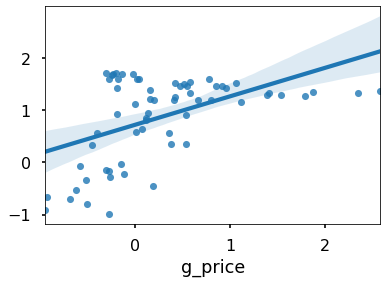

In [852]:
sns.regplot(expected_y, predicted_y, fit_reg=True, scatter_kws={"s": 50})

Hypertuning LightGBM 

In [853]:
model_lgbm2= ltb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [854]:
from sklearn.metrics import r2_score
model_lgbm2.fit(x_train, y_train)
expected_y=y_test
predicted_y = model_lgbm2.predict(x_test)

print('r2_score: %.2f'% r2_score(expected_y, predicted_y))
print('rmse: %.2f ' % np.sqrt(mean_squared_error(expected_y, predicted_y)))

r2_score: -0.74
rmse: 0.96 


In [855]:
model_lgbm2.fit(x_train, y_train)
expected_y=y_test
predicted_y = model_lgbm2.predict(x_test)
print('r2_score: %.2f'% r2_score(expected_y, predicted_y))
print('rmse: %.2f ' % np.sqrt(mean_squared_error(expected_y, predicted_y)))

r2_score: -0.74
rmse: 0.96 


In [856]:
model_lgbm3= ltb.LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1,         #boosting_type,num_leaves, n_estimators
       importance_type='split', learning_rate=0.01, max_depth=6,          
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=200, num_leaves=50, objective=None,
       random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [857]:
model_lgbm3.fit(x_train, y_train)
expected_y=y_test
predicted_y_dart = model_lgbm3.predict(x_test)
print('r2_score: %.2f'% r2_score(expected_y, predicted_y_dart))
print('rmse: %.2f ' % np.sqrt(mean_squared_error(expected_y, predicted_y_dart)))

r2_score: 0.28
rmse: 0.62 


In [858]:
expected_y

DATE
2016-08-01   -0.510344
2016-09-01   -0.622390
2016-10-01   -0.448361
2016-11-01   -0.276716
2016-12-01   -0.300556
                ...   
2021-07-01    1.535093
2021-08-01    1.785408
2021-09-01    2.338487
2021-10-01    2.576883
2021-11-01    1.866463
Name: g_price, Length: 64, dtype: float64

In [859]:
predictions=pd.DataFrame(predicted_y_dart, index= expected_y.index)

LGBM regressor with 'dart' boosting type --> model_lgbm3

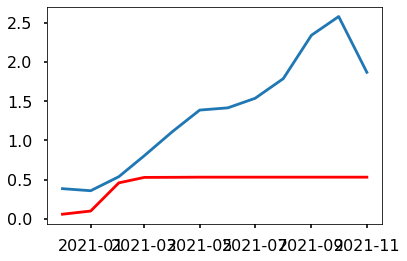

In [860]:
plt.plot(expected_y[-12:])
plt.plot(predictions[-12:], color='red')
plt.show()

In [861]:
#Boosting on a std scaler data:

In [862]:
al.columns

Index(['g_price', 'prod', 'inv', 'demand', 'PPI', 'ch_g_price', 'ch_prod',
       'ch_inv', 'ch_demand', 'ch_PPI'],
      dtype='object')

In [863]:
x_train= al[['ch_prod', 'ch_inv', 'ch_demand', 'ch_PPI']][:-64]
y_train= al['ch_g_price'][:-64]
x_test= al[['ch_prod','ch_inv', 'ch_demand', 'ch_PPI']][-64:]
y_test= al['ch_g_price'][-64:]

In [864]:
model_lgbm3.fit(x_train, y_train)
expected_y=y_test
predicted_y = model_lgbm3.predict(x_test)
print('r2_score: %.3f'% r2_score(expected_y, predicted_y))
print('rmse: %.3f'% (np.sqrt(mean_squared_error(expected_y, predicted_y))))  

r2_score: 0.078
rmse: 0.038


# 6. Time Series CV (systematic sampling)



# f. Linear Regression for Al price

In [865]:
al.head()

,g_price,prod,inv,demand,PPI,ch_g_price,ch_prod,ch_inv,ch_demand,ch_PPI
DATE,,,,,,,,,,
1995-01-01,2059,101,8535,6210,162,NaN,NaN,NaN,NaN,NaN
1995-02-01,1905,100,8635,5940,170,-0.07,-0.01,0.01,-0.04,0.05
1995-03-01,1799,97,8712,6037,174,-0.06,-0.03,0.01,0.02,0.02
1995-04-01,1849,100,8773,6177,178,0.03,0.03,0.01,0.02,0.02
1995-05-01,1765,96,8724,5797,176,-0.05,-0.04,-0.01,-0.06,-0.01


In [866]:
al.columns

Index(['g_price', 'prod', 'inv', 'demand', 'PPI', 'ch_g_price', 'ch_prod',
       'ch_inv', 'ch_demand', 'ch_PPI'],
      dtype='object')

### 23.a  single output using LR - Systematic sampling (last 30)

In [867]:
indep= al['g_price']

dep=dependent.to_numpy()
al_global_price=indep.to_numpy()

T=60
#Ty=Ntest=6
X=[]
Y=[]

for t in range(len(al_global_price)-(T)):
    x= al_global_price[t:t+T]
    X.append(x)
    
#for t in range(len(indep)-(Tx+Ty-1)):
    y= al_global_price[t+T]
    Y.append(y)
    
    
X= np.array(X).reshape(-1, 60*1)                #T*(No. of columns for independent table)
Y= np.array(Y)

#N= len(Y)


In [868]:
X.shape

(263, 60)

In [869]:
Ntest= 30                                                                #Systematic sampling (last 30) for validation

Xtrain, Ytrain= X[:-Ntest], Y[:-Ntest]
Xtest, Ytest= X[-Ntest:], Y[-Ntest:]                                     #times split

lr=LinearRegression()
lr.fit(Xtrain,Ytrain)                        
lr.score(Xtrain, Ytrain)

y_pred=lr.predict(Xtest)

from sklearn import metrics
    
print('r2_score: ',metrics.r2_score(Ytest, y_pred)) 
print(f'MSE: %.3f '% metrics.mean_squared_error(Ytest,y_pred))
print(f'RMSE: ', np.sqrt(metrics.mean_squared_error(Ytest,y_pred )))
print(f'MAPE: ', metrics.mean_absolute_percentage_error(Ytest,y_pred)*100)
print(f'MAE: ', metrics.mean_absolute_error(Ytest,y_pred))

r2_score:  0.9368846350332132
MSE: 10287.051 
RMSE:  101.42510198613387
MAPE:  3.977348346230004
MAE:  80.45337130333752


### 23.b-  single output using LR- 10% random sampling

r2_score:  0.9403771958909178
MSE: 8188.941 
RMSE:  90.49276527561857
MAPE:  3.5991085443985154
MAE:  72.92078493230699


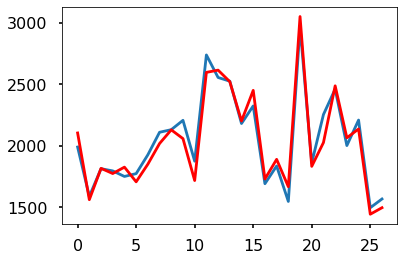

In [870]:
#Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

Xtrain, Xtest, Ytrain, Ytest= train_test_split(X,Y, test_size=0.10, random_state= 5)            #normal split

lr=LinearRegression()
lr.fit(Xtrain,Ytrain)                        
lr.score(Xtrain, Ytrain)

y_pred=lr.predict(Xtest)

from sklearn import metrics
    
print('r2_score: ',metrics.r2_score(Ytest, y_pred)) 
print(f'MSE: %.3f '% metrics.mean_squared_error(Ytest,y_pred))
print(f'RMSE: ', np.sqrt(metrics.mean_squared_error(Ytest,y_pred )))
print(f'MAPE: ', metrics.mean_absolute_percentage_error(Ytest,y_pred)*100)
print(f'MAE: ', metrics.mean_absolute_error(Ytest,y_pred))
    
#sns.scatterplot(y_pred,Ytest) 


plt.plot(Ytest)
plt.plot(y_pred, color='red')
plt.show()

### 24.a- Single output using LR - Log (Inventory, demand, PPI)-  Systematic sampling (last 30)

In [871]:
dependent=np.log(al[['inv', 'demand', 'PPI']])
indep= al['g_price']

dep=dependent.to_numpy()
sde=indep.to_numpy()

Tx=T=60
#Ty=Ntest=6
X=[]
Y=[]

for t in range(len(dependent)-(Tx)):
    x= dependent[t:t+Tx]
    X.append(x)
    
for t in range(len(indep)-(Tx)):
    y= indep[t+Tx]
    Y.append(y)
    
    
X= np.array(X).reshape(-1, 60*3)                #T*(No. of columns for independent table)
Y= np.array(Y)                #.reshape(-1, Ty)

#N= len(Y)


In [872]:
Ntest= 30

Xtrain, Ytrain= X[:-Ntest], Y[:-Ntest]
Xtest, Ytest= X[-Ntest:], Y[-Ntest:]                                                #times split

lr=LinearRegression()
lr.fit(Xtrain,Ytrain)                        
lr.score(Xtrain, Ytrain)

y_pred=lr.predict(Xtest)

from sklearn import metrics
    
print('r2_score: ',metrics.r2_score(Ytest, y_pred)) 
print(f'MSE: %.3f '% metrics.mean_squared_error(Ytest,y_pred))
print(f'RMSE: ', np.sqrt(metrics.mean_squared_error(Ytest,y_pred )))
print(f'MAPE: ', metrics.mean_absolute_percentage_error(Ytest,y_pred)*100)
print(f'MAE: ', metrics.mean_absolute_error(Ytest,y_pred))

r2_score:  -10.217366039903805
MSE: 1828296.804 
RMSE:  1352.1452599244817
MAPE:  47.156557166762596
MAE:  1034.9811189991538


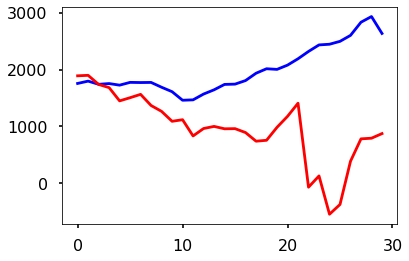

In [873]:
plt.plot(Ytest, color= 'blue')
plt.plot(y_pred, color='red')
plt.show()

### 24.b-  single output using LR- Log (Inventory, demand, PPI)- 10% random sampling

In [874]:
#Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

Xtrain, Xtest, Ytrain, Ytest= train_test_split(X,Y, test_size=0.10, random_state= 5)     #10% random sampling for Validation

lr=LinearRegression()
lr.fit(Xtrain,Ytrain)                        
lr.score(Xtrain, Ytrain)

y_pred=lr.predict(Xtest)

from sklearn import metrics
    
print('r2_score: ',metrics.r2_score(Ytest, y_pred)) 
print(f'MSE: %.3f '% metrics.mean_squared_error(Ytest,y_pred))
print(f'RMSE: ', np.sqrt(metrics.mean_squared_error(Ytest,y_pred )))
print(f'MAPE: ', metrics.mean_absolute_percentage_error(Ytest,y_pred)*100)
print(f'MAE: ', metrics.mean_absolute_error(Ytest,y_pred))
    
#sns.scatterplot(y_pred,Ytest) 

r2_score:  -0.24586358910047923
MSE: 171114.107 
RMSE:  413.6594095001662
MAPE:  16.16167221090453
MAE:  328.95292622789134


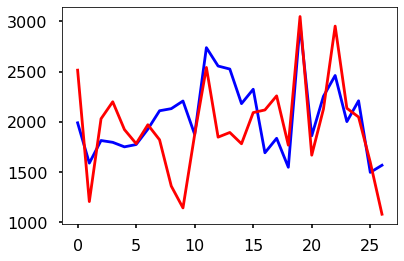

In [875]:
plt.plot(Ytest, color= 'blue')
plt.plot(y_pred, color='red')
plt.show()

In [876]:
dependent                     #log data

,inv,demand,PPI
DATE,,,
1995-01-01,9.051931,8.733916,5.087596
1995-02-01,9.063579,8.689464,5.135798
1995-03-01,9.072457,8.705662,5.159055
1995-04-01,9.079434,8.728588,5.181784
1995-05-01,9.073833,8.665096,5.170484
...,...,...,...
2021-07-01,9.377633,8.875706,5.411646
2021-08-01,9.384378,8.841882,5.446737
2021-09-01,9.386728,8.813290,5.476464


### 25.a- Multiple output using LR (Tx=60, Ty=3) - Systematic sampling (last 30)

In [877]:
#Only with price - Multi Output   ----->> Corrected indep
indep= al['g_price']


Tx=T=60
Ty=Ntest=3
X=[]
Y=[]

for t in range(len(indep)-(Tx+Ty-1)):
    x= indep[t:t+Tx]
    X.append(x)
    
#for t in range(len(indep)-(Tx+Ty-1)):
    y= indep[t+Tx: t+Tx+Ty]
    Y.append(y)
    
    
X= np.array(X).reshape(-1,Tx)               #T*(No. of columns for independent table)
Y= np.array(Y).reshape(-1,Ty)

#N= len(Y)


In [878]:
Ntest= 30

Xtrain, Ytrain= X[:-Ntest], Y[:-Ntest]
Xtest, Ytest= X[-Ntest:], Y[-Ntest:]                                                #times split

lr=LinearRegression()
lr.fit(Xtrain,Ytrain)                        
lr.score(Xtrain, Ytrain)

y_pred=lr.predict(Xtest)

from sklearn import metrics
    
print('r2_score: ',metrics.r2_score(Ytest, y_pred)) 
print(f'MSE: %.3f '% metrics.mean_squared_error(Ytest,y_pred))
print(f'RMSE: ', np.sqrt(metrics.mean_squared_error(Ytest,y_pred )))
print(f'MAPE: ', metrics.mean_absolute_percentage_error(Ytest,y_pred)*100)
print(f'MAE: ', metrics.mean_absolute_error(Ytest,y_pred))

r2_score:  0.8492714805657506
MSE: 22965.478 
RMSE:  151.54365062178198
MAPE:  5.694506387721526
MAE:  113.44213122814763


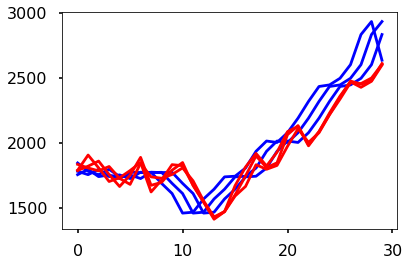

In [879]:
plt.plot(Ytest, color= 'blue')
plt.plot(y_pred, color='red')
plt.show()

### 25.b- Multiple output using LR (Tx=60, Ty=3) - 10% random sampling

In [880]:
#Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

Xtrain, Xtest, Ytrain, Ytest= train_test_split(X,Y, test_size=0.10, random_state= 5)            #normal split

lr=LinearRegression()
lr.fit(Xtrain,Ytrain)                       
lr.score(Xtrain, Ytrain)

y_pred=lr.predict(Xtest)

from sklearn import metrics
    
print('r2_score: ',metrics.r2_score(Ytest, y_pred)) 
print(f'MSE: %.3f '% metrics.mean_squared_error(Ytest,y_pred))
print(f'RMSE: ', np.sqrt(metrics.mean_squared_error(Ytest,y_pred )))
print(f'MAPE: ', metrics.mean_absolute_percentage_error(Ytest,y_pred)*100)
print(f'MAE: ', metrics.mean_absolute_error(Ytest,y_pred))
    
#sns.scatterplot(y_pred,Ytest) 

r2_score:  0.8275780366768957
MSE: 34383.188 
RMSE:  185.4270431388732
MAPE:  6.3959420575219905
MAE:  132.7275846074326


In [881]:
al['g_price'].std()

420.1211161389454

In [882]:
#Using Systematic sampling for Random Forest

rf=RandomForestRegressor()
rf.fit(Xtrain,Ytrain)                        
rf.score(Xtrain, Ytrain)

y_pred=rf.predict(Xtest)

from sklearn import metrics
    
print('r2_score: ',metrics.r2_score(Ytest, y_pred)) 
print(f'MSE: %.3f '% metrics.mean_squared_error(Ytest,y_pred))
print(f'RMSE: ', np.sqrt(metrics.mean_squared_error(Ytest,y_pred )))
print(f'MAPE: ', metrics.mean_absolute_percentage_error(Ytest,y_pred)*100)
print(f'MAE: ', metrics.mean_absolute_error(Ytest,y_pred))

r2_score:  0.9200182400146684
MSE: 15836.144 
RMSE:  125.84174079345027
MAPE:  4.787152729573501
MAE:  95.71209876543212
